
# SVD Application for Occluded Face Recognition

## Objective
To explore how SVD can be applied to detect and reconstruct occluded faces in facial recognition.

Singular Value Decomposition (SVD) is a powerful matrix factorization technique that can be used for image reconstruction. 

This project aims to detect and reconstruct occluded faces by leveraging PCA on preprocessed facial image data.

SVD alone does not select dimensions to reduce the data. PCA selects the principal components from the results of SVD to achieve dimensionality reduction.

PCA captures the principal components with the most variance in the data. 

Facial recognition tasks involves processing high dimentainal image data. 

PCA reduces the dimensionality while retaining the most significant information.



## Methods
The methods implemented so far include:
1. Image preprocessing: Grayscale conversion, resizing, and normalization.
2. SVD application: Decomposing images into singular values and vectors.
3. Reconstruction: Using reduced components for reconstructing images.


Current augmented dataset has 36 subjects with 440 masked images and 809 control (neutral faces) images 

### Preproccesing

In [40]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [41]:
def preprocess_image(image_path, target_size=(64, 64)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:  
        print(f"load image error: {image_path}")
        return None
    try:
        image = cv2.resize(image, target_size)
        image = image / 255.0 
        return image
    except Exception as e:
        print(f"processing  error {image_path}: {e}")
        return None

base_path = '/Users/amanda/Desktop/ROF_proj/images'
categories = ['neutral', 'masked']
processed_images = {}

for category in categories:
    category_path = os.path.join(base_path, category)
    processed_images[category] = []
    
    for celeb_folder in os.listdir(category_path):
        celeb_folder_path = os.path.join(category_path, celeb_folder)
        
        if not os.path.isdir(celeb_folder_path):
            continue
        
        jpg_files = [f for f in os.listdir(celeb_folder_path) if f.endswith('.jpg')]
        
        for filename in jpg_files:
            image_path = os.path.join(celeb_folder_path, filename)
            image = preprocess_image(image_path)
            processed_images[category].append(image)

### Apply SVD

In [42]:
def apply_svd(image, k=40):
   U, S, Vt = np.linalg.svd(image, full_matrices=False)
   S_k = np.diag(S[:k])
   U_k = U[:, :k]
   Vt_k = Vt[:k, :]
  
   image_reconstructed = np.dot(U_k, np.dot(S_k, Vt_k))
   return image_reconstructed

In [43]:
for category in categories:
    category_path = os.path.join(base_path, category)
    processed_images[category] = []
  
    for celeb_folder in os.listdir(category_path):
        celeb_folder_path = os.path.join(category_path, celeb_folder)
      
        if not os.path.isdir(celeb_folder_path):
            continue
      
        jpg_files = [f for f in os.listdir(celeb_folder_path) if f.endswith('.jpg')]
      
        for filename in jpg_files:
            image_path = os.path.join(celeb_folder_path, filename)
            image = preprocess_image(image_path)
            processed_images[category].append(image)


SVD on image matrix: $A = U \Sigma V^t$
- $U$: $\text{m x m}$ orthogonal matrix of left singular vectors of $A$.
- $\Sigma$: $\text{m x n}$ diagonal matrix and are singular values of $A$
- $V^t$: $\text{n x n}$ transposed orthogonal matrix of. $V$ right singular vectors of $A$.


To reduce top # of to $k$ values: $\text{Reconstructed Image} = U_k \Sigma_kV_k^t$
- $U_k$: The first $k$ columns of $U$
- $\Sigma_k$: diagonal matrix of the top $k$ singular values
- $V_k^t$: The first $k$ rows of $V^t$

### Result of SVD Reconstruction

In [44]:
svd_images = {}
for category in categories:
   svd_images[category] = []
   for image in processed_images[category]:
       svd_images[category].append(apply_svd(image))



def visualize_image_comparison(original, reconstructed):
   fig, axes = plt.subplots(1, 2)
   axes[0].imshow(original, cmap='gray')
   axes[0].set_title('Original Image')
   axes[1].imshow(reconstructed, cmap='gray')
   axes[1].set_title('SVD Reconstructed Image')
   plt.show()

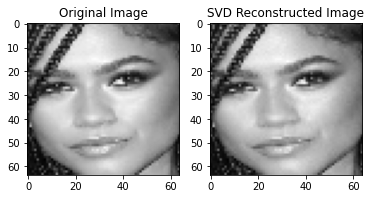

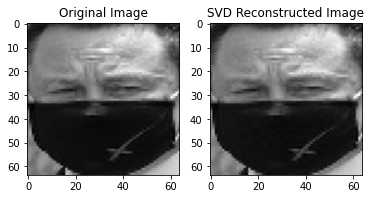

In [45]:
for category in categories:
   original_image = processed_images[category][6] 
   reconstructed_image = svd_images[category][6]
   visualize_image_comparison(original_image, reconstructed_image)


In [46]:
def stack_images_nested(base_path, target_size=(64, 64)):
    image_list = []
    for subject_folder in os.listdir(base_path): 
        subject_path = os.path.join(base_path, subject_folder)
        if os.path.isdir(subject_path):  
            for filename in os.listdir(subject_path):  
                image_path = os.path.join(subject_path, filename)
                if os.path.isfile(image_path) and filename.lower().endswith(('.jpg')): 
                    processed_image = preprocess_image(image_path, target_size)
                    if processed_image is not None: 
                        image_list.append(processed_image.flatten()) 
    return np.array(image_list)  

In [47]:
def process_category(base_path, target_size=(64, 64)):
    image_matrix = stack_images_nested(base_path, target_size) 
    Xmean = np.mean(image_matrix, axis=0) # mean face 
    normalized = image_matrix - Xmean
    return normalized, Xmean

def compute_pca(normalized):
    n_samples, n_features = normalized.shape
    n_components = min(n_samples, n_features)
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False)
    pca.fit(normalized)
    S = pca.singular_values_
    lam = S**2  
    variances = np.cumsum(lam) / np.sum(lam)  
    return variances, n_components


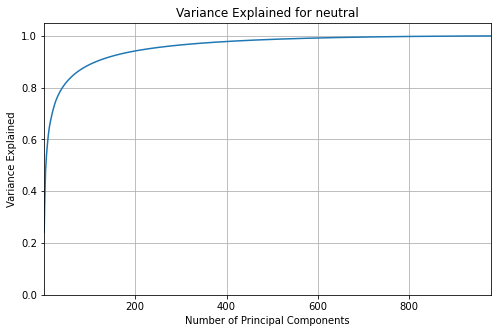

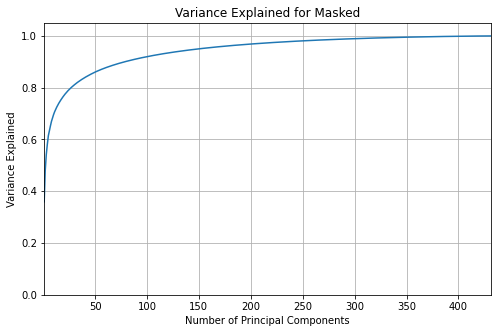

In [ ]:
neutral_path = '/Users/amanda/Desktop/ROF_proj/images/neutral'
neutral_X, neutral_Xmean = process_category(neutral_path)
neutral_var, neutral_n_components = compute_pca(neutral_X)

masked_path = '/Users/amanda/Desktop/ROF_proj/images/masked'
masked_X, masked_Xmean = process_category(masked_path)
masked_var, masked_n_components = compute_pca(masked_X)


plt.figure(figsize=(8, 5))
plt.plot(range(1, neutral_n_components + 1), neutral_var)
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained for neutral')
plt.axis([1, neutral_n_components, 0, 1.05])
plt.grid()


plt.figure(figsize=(8, 5))
plt.plot(range(1, masked_n_components + 1), masked_var)
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained for Masked')
plt.axis([1, masked_n_components, 0, 1.05]) 
plt.grid()



### PCA

Eigenfaces are principal components in image space, highlighting dominant patterns across all images. Each eigenface contains a <br>
distinct characteristic, such as lighting, facial structure, or general pose.


1. Flatten and Stack images
- Flattens processed images into 1D arrays and stacks them into a 2D array imagem atrix (rows represent images, and columns <br>
represent pixel values)
   - Stacking images is crucial as it transforms them into a format that enables dimensionality reduction, enhances pattern recognition,
    and aids in the visualization of prominent features. These steps are essential for tasks such as facial recognition

2. Subtract it out of mean faces to improve features

3. Perform SVD on the normalized images : $$A = U \Sigma V^t$$
- $U$: Left singular vectors (specific to images)
- $\Sigma $: Singular values (variance explained by each component)
- $V^t$:  Right singular vectors, represents principal components or eigenfaces

4. Eigenface Visualizaion 
- Displays the first few rows of $V^t$ 


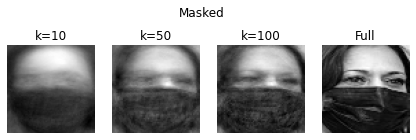

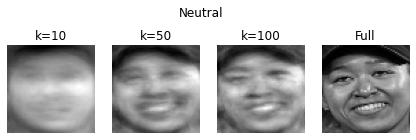

In [53]:
# I used https://github.com/sdrangan/introml/blob/master/unit11_pca/demo1_eigen_face.ipynb as a refrence for pca 
def plt_face(data, title=None):
    plt.imshow(data.reshape(64, 64), cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title)

base_paths = [
    '/Users/amanda/Desktop/ROF_proj/images/masked',
    '/Users/amanda/Desktop/ROF_proj/images/neutral'
]

ks = [10, 50, 100] 
nplt = 1  

for idx, base_path in enumerate(base_paths):
    image_matrix = stack_images_nested(base_path, target_size=(64, 64))  
    mean_face = np.mean(image_matrix, axis=0)
    centered_images = image_matrix - mean_face

    # SVD
    U, Sigma, Vt = np.linalg.svd(centered_images, full_matrices=False)

    # Direct PCA features
    Z = np.dot(centered_images, Vt.T)  # Perform PCA

    n_samples = centered_images.shape[0]
    inds = np.random.permutation(n_samples)[:nplt]
    nd = len(ks)

    plt.figure(figsize=(1.8 * (nd + 1), 2.4 * nplt))
    plt.suptitle('Masked' if idx == 0 else 'Neutral')

    iplt = 0
    for ind in inds:
        for k in ks:
            plt.subplot(nplt, nd + 1, iplt + 1)
            top_k = np.copy(Z[ind, :k])  # uses first k comp
            reconstructed = np.dot(top_k, Vt[:k, :]) 
            plt_face(reconstructed + mean_face, title=f'k={k}')
            iplt += 1

    # plt original face
    plt.subplot(nplt, nd + 1, iplt + 1)
    plt_face(centered_images[ind, :] + mean_face, title='Full')
    iplt += 1

masked_path = base_paths[0]
masked_stacked = stack_images_nested(masked_path, target_size=(64, 64))
masked_mean_face = np.mean(masked_stacked, axis=0)
masked_X = masked_stacked - masked_mean_face

category = "neutral"
neutral_images = stack_images_nested(base_paths[1], target_size=(64, 64))
neutral_mean_face = np.mean(neutral_images, axis=0)
normalized_imgs = neutral_images - neutral_mean_face

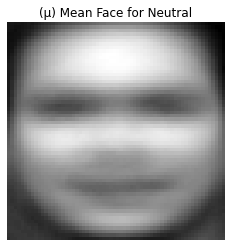

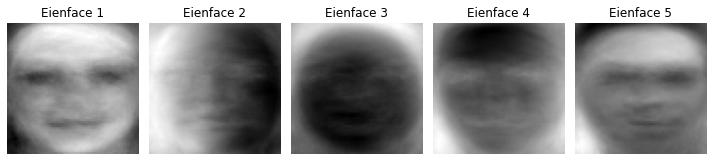

In [50]:
neutal_path = '/Users/amanda/Desktop/ROF_proj/images/neutral'
neutral_stacked = stack_images_nested(neutal_path, target_size=(64, 64))
neutral_Xmean = np.mean(neutral_stacked, axis=0)  # Mean face
neutal_normed = neutral_stacked - neutral_Xmean  

plt.imshow(neutral_Xmean.reshape(64, 64), cmap="gray")
plt.title("(μ) Mean Face for Neutral")
plt.axis("off")
plt.show()

pca = PCA(svd_solver='randomized', whiten=False) 
pca.fit(neutal_normed)  
Vt = pca.components_ 

# plt # of eigenfaces
nplt = 5  
plt.figure(figsize=(10, 20))

for i in range(nplt):
    plt.subplot(1, nplt, i + 1)
    plt_face(Vt[i, :])  
    plt.title(f'Eienface {i + 1}')  

plt.tight_layout()
plt.show()

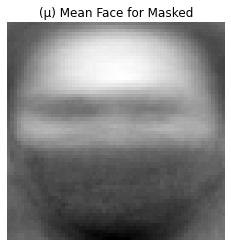

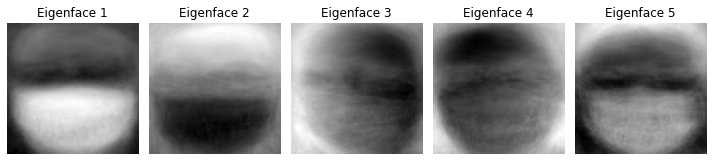

In [51]:
masked_path = '/Users/amanda/Desktop/ROF_proj/images/masked'
masked_stacked = stack_images_nested(masked_path, target_size=(64, 64))  
masked_Xmean = np.mean(masked_stacked, axis=0)  
plt.imshow(masked_Xmean.reshape(64, 64), cmap="gray")
plt.title("(μ) Mean Face for Masked")
plt.axis("off")
plt.show()

masked_normed = masked_stacked - masked_Xmean  

# Perform PCA with svd solver
pca = PCA(svd_solver='randomized', whiten=False)  
pca.fit(masked_normed) 
Vt = pca.components_ 

nplt = 5
plt.figure(figsize=(10, 20))

for i in range(nplt):
    plt.subplot(1, nplt, i + 1)
    plt_face(Vt[i, :])  # Visualize the eigenface
    plt.title(f'Eigenface {i + 1}')  # Principal Component index

plt.tight_layout()
plt.show()

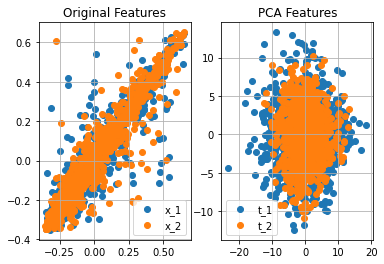

In [52]:
pca = PCA(n_components=neutral_n_components, svd_solver='randomized', whiten=False)
neutral_pca_components = pca.fit_transform(neutral_X)

plt.subplot(1, 2, 1)
plt.scatter(neutral_X[:, 0], neutral_X[:, 1], label="x_1" )
plt.scatter(neutral_X[:, 1], neutral_X[:, 2], label="x_2")
plt.title("Original Features")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(neutral_pca_components[:, 0], neutral_pca_components[:, 1], label="t_1")
plt.scatter(neutral_pca_components[:, 1], neutral_pca_components[:, 2], label="t_2")
plt.title("PCA Features")
plt.legend()
plt.grid()

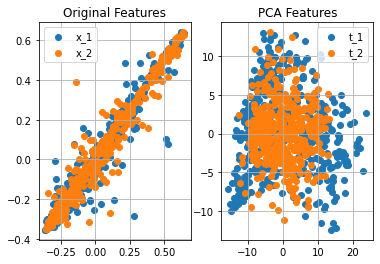

In [ ]:
pca = PCA(n_components=masked_n_components, svd_solver='randomized', whiten=False)
masked_pca_components = pca.fit_transform(masked_X)

plt.subplot(1, 2, 1)
plt.scatter(masked_X[:, 0], masked_X[:, 1], label="x_1" )
plt.scatter(masked_X[:, 1], masked_X[:, 2], label="x_2")
plt.title("Original Features")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(masked_pca_components[:, 0], masked_pca_components[:, 1], label="pc_1")
plt.scatter(masked_pca_components[:, 1], masked_pca_components[:, 2], label="pc_2")
plt.title("PCA Features")
plt.legend()
plt.grid()



## Limitations
- Since  the original dataset has such small images we decided to scale the images down which led to loss <br> of image quality even if the original image was high res
